ADD COLAB BADGE (kida) 

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip -d dataset
!rm ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip

In [1]:
import csv
import hashlib
import os
import pathlib
import pickle
import random
import re
import string
import timeit
import unicodedata
from collections import defaultdict
from itertools import combinations
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn.functional as F
from scipy.optimize import fsolve
from scipy.stats import kendalltau, spearmanr
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

In [2]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Implementation

## Hash utils

In [3]:
def is_prime(n: int) -> bool:
    if n < 2:
        return False
    for i in range(2, int(np.sqrt(n))+1):
        if (n % i) == 0:
            return False
    return True

def find_closest_prime(n: int) -> int:
    """Finds the closest prime number higher than input."""
    while True:
        if is_prime(n):
            return n
        n += 1

def get_variable_length_hash(
    n_bits: int
) -> Callable[[str], int]:
    """Generates a hash function that takes a string
    as input and has 2 ** n_bits integer buckets.
    """
    def inner_f(s: str) -> int:
        binary_str = bin(
            int.from_bytes(
                hashlib.sha256(s.encode()).digest(), 
                'little'
            )
        )[-n_bits:]
        return int(binary_str, 2)
    return inner_f

class HashGenerator:
    """Generator of hash functions of the form:
            h(x) = (ax + b) mod c
    where x is a row number, a and b are random numbers
    smaller than the maximum row number and c is a prime
    number higher than the maximum row number.

    Note that a and b must be unique for a given signature
    matrix.

    This approach to hash function generation was suggested
    in [1].

    Parameters
    ----------
    num_rows : int
        Maximum number of rows of the characteristic matrix.

    References
    ----------
        [1] http://ethen8181.github.io/machine-learning/clustering_old/text_similarity/text_similarity.html

    """
    def __init__(
        self, 
        num_rows: int, 
    ) -> None:
        self.num_rows = num_rows
        self.prime = find_closest_prime(num_rows)
        self.a_set = set()
        self.b_set = set()

    def get_num_rows(self) -> int:
        return self.num_rows

    def next(self) -> Callable[[np.uint32], np.uint32]:
        """Returns a hash function that takes a row number 
        as input and returns another row number as output.
        """
        a = self._generate_coeff(self.a_set, self.num_rows)
        b = self._generate_coeff(self.b_set, self.num_rows)
        return lambda row: np.uint32((a * row + b) % self.prime)

    def _generate_coeff(
        self, 
        coeff_set: set[int],
        max_val: int
    ) -> int:
        while True:
            coeff = random.randint(1, max_val)
            if coeff not in coeff_set:
                coeff_set.add(coeff)
                return coeff

## Preprocessing utils

In [4]:
def normalize_white_space(doc: str) -> str:
    return " ".join(doc.split())

def remove_https(doc: str) -> str:
    return re.sub(r'https?://[^ ]+', '', doc)

def replace_chars(doc: str) -> str:
    return doc.replace('&amp;', ' and ')

def remove_non_ascii(doc: str) -> str:
    """Removes non ascii and non printable characters.
    We keep cyrillic characters due to the nature
    of the dataset.
    """
    cyr_chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"

    res = ""
    for c in doc:
        if (c.isascii() and c.isprintable()) \
            or (c in cyr_chars) or c.isspace():
            res += c
    return res

def strip_accents(doc: str) -> str:
    """Replaces words with accent with their 
    counterpart without accent. This also deals with 
    special characters such as 𝕒, 𝕕, 𝕖, 𝙖, 𝙘, 𝙙. 
    """
    return unicodedata.normalize('NFKD', doc)

def strip_punctuation(doc: str) -> str:
    return re.sub('[' + re.escape(string.punctuation) + ']', '', doc)
    
def get_lemmatizer( 
    nlp: spacy.pipeline, 
    allow_stop_words: bool = False,
    allow_punct: bool = False,
    allow_numbers: bool = False
) -> Callable[[str], str]:
    """Generates a function that takes a string as
    input and returns the string sequence of lemmas
    in the input string. Optionally, the generated
    function removes stop words, punctuation and
    numbers.

    Note that numbers are tokens identified as such.
    For instance, '62,000' is a number, but 'T-72' is
    not.

    Parameters
    ----------
    nlp : spacy.pipeline
        Spacy object that carries out the lemmatization.
    
    allow_stop_words : bool
        Boolean value to filter or allow stop words.

    allow_punct : bool
        Boolean value to filter or allow punctuation.
    
    allow_numbers : bool
        Boolean value to filter or allow numbers.

    Returns
    -------
    The generated function. 
    """
    def inner_f(doc: str) -> str:
        return ' '.join(
            [
                token.lemma_
                for token in nlp(doc)
                if (not token.is_stop or allow_stop_words) \
                    and (not token.is_punct or allow_punct) \
                    and (token.pos_ != 'NUM' or allow_numbers) \
                    and (not token.pos_ == 'X')
            ]
        )
    return inner_f

## Model

In [59]:
def jaccard_similarity(
    x: np.ndarray, 
    y: np.ndarray
) -> float:
    numerator = len(set(x).intersection(set(y)))
    denominator = len(set(x).union(set(y)))
    return numerator / denominator

class LSHModel:
    """Implementation of LSH model that finds similar pairs
    of documents encoded as k-gram shingles.

    Parameters
    ----------
    k : int
        Number of characters in each k-gram.

    threshold : float
        The similarity value required to consider a
        pair as similar.

    num_hashes : int
        Number of hash functions used to generate the
        signature matrix.

    shingle_hash_bits : int
        Determines the number of buckets of the hash
        function that maps each shingle to an integer.

    track_shingles : bool
        Flag to keep track of the number of different
        shingles found in the corpus, as well as the
        number of different characters in the shingles.

    checkpoint_path : Optional[str]
        Path to save and load the state of the model.

    Exceptions
    ----------
    ValueError
        If the number of hash functions is higher than the
        number of rows of the characteristic matrix (which is
        also the number of shingles). This is due to the fact
        that the the coefficients 'a' and 'b' of the hash
        functions generated by HashGenerator need to be unique
        within the given signature matrix.
    """
    def __init__(
        self,
        k: int,
        threshold: float,
        num_hashes: int,
        shingle_hash_bits: int,
        track_shingles: bool = False,
        checkpoint_path: Optional[str] = None
    ) -> None:
        self.k = k
        self.threshold = threshold
        self.num_hashes = num_hashes
        self.shingle_set = set()
        self.char_set = set()
        self.shingle_hash_bits = shingle_hash_bits
        self.shingle_hash = get_variable_length_hash(
            shingle_hash_bits
        )
        self.num_shingles = 2 ** shingle_hash_bits
        self.track_shingles = track_shingles
        self.checkpoint_path = checkpoint_path
        self.num_docs = 0
        self.docs_dict = dict()
        self.signature = None
        self.candidate_pairs = set()
        self.fp_pairs = set()
        self.similar_pairs = set()
        self.b = -1
        self.r = -1
        self.sig_idx = -1

        if self.num_hashes > self.num_shingles:
            raise ValueError(
                f"Number of hash functions must be lower than "
                f"or equal to the number of shingles. Found "
                f"{self.num_hashes} hash functions and "
                f"{self.num_shingles} shingles."
            )

    def load_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', 'docs_dict'),
                (f'{self.checkpoint_path}/shingle_set.npy', 'shingle_set'),
                (f'{self.checkpoint_path}/char_set.npy', 'char_set'),
                (f'{self.checkpoint_path}/signature.npy', 'signature'),
                (f'{self.checkpoint_path}/sig_idx.npy', 'sig_idx'),
                (f'{self.checkpoint_path}/candidate_pairs.npy', 'candidate_pairs'),
                (f'{self.checkpoint_path}/fp_pairs.npy', 'fp_pairs'),
                (f'{self.checkpoint_path}/similar_pairs.npy', 'similar_pairs')
            ]

            for file_path, attr in tup_ls:
                if os.path.isfile(file_path):
                    if attr in ['signature']:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True)
                        )
                    else:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True).item()
                        )
                        
    def save_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            os.makedirs(self.checkpoint_path, exist_ok=True)

            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', self.docs_dict),
                (f'{self.checkpoint_path}/shingle_set.npy', self.shingle_set),
                (f'{self.checkpoint_path}/char_set.npy', self.char_set),
                (f'{self.checkpoint_path}/signature.npy', self.signature),
                (f'{self.checkpoint_path}/sig_idx.npy', self.sig_idx),
                (f'{self.checkpoint_path}/candidate_pairs.npy', self.candidate_pairs),
                (f'{self.checkpoint_path}/fp_pairs.npy', self.fp_pairs),
                (f'{self.checkpoint_path}/similar_pairs.npy', self.similar_pairs)
            ]

            for file_path, val in tup_ls:
                np.save(file_path, val)

    def add_document(
        self, 
        doc: str,
        preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None
    ) -> None:
        """Creates shingles from the document given in input and
        adds those shingles to the model. Optionally, the document
        is preprocessed with a number of functions given in a 
        pipeline.

        Parameters
        ----------
        doc : str
            String document to be processed.

        preprocessing_pipeline : Optional[list[Callable[[str], str]]]
            List of functions that take a string and return a string.
            This is used to filter stop words, apply lemmatization, etc.
        """
        if preprocessing_pipeline is not None:
            for f in preprocessing_pipeline:
                doc = f(doc)
        
        shingles = self._create_shingles(
            doc, 
            self.k,
            self.track_shingles,
            self.shingle_hash
        )

        self.docs_dict[self.num_docs] = shingles
        self.num_docs += 1

    def get_similar_pairs(
        self,
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> set[tuple[tuple[int, int], float]]:
        """Returns the pairs having an approximated similarity 
        higher than a fixed threshold. The pairs are provided as 
        a set of tuples containing the indices of the documents and
        their similarity value. 
        
        The approximated similarity measure is the Jaccard
        similarity.

        This function also saves the false positive pairs identified
        after double-checking the signature matrix.

        Parameters
        ----------
        checkpoint_path : Optional[str]
            Path to save and load the state of the model. This is used
            when building the signature matrix.

        checkpoint_freq : int
            Frequency with which the state of the model is saved.
        
        Returns
        -------
        The set of pairs approximately similar, alongside their 
        similarity value.
        """
        hg = HashGenerator(self.num_shingles)
        hash_functions = [
            hg.next()
            for _ in range(self.num_hashes)
        ]
        self.signature = self._build_signature(
            self.docs_dict,
            self.num_shingles,
            hash_functions,
            checkpoint_path,
            checkpoint_freq
        )
        self.b, self.r = self._find_lsh_params(
            self.threshold,
            self.num_hashes
        )
        self.candidate_pairs = self._lsh(
            self.signature,
            self.b
        )
        self.similar_pairs, self.fp_pairs = \
            self._check_threshold_on_signature(
                self.candidate_pairs,
                self.signature,
                self.threshold
            )
        return self.similar_pairs

    def _create_shingles(
        self,
        doc: str, 
        k: int,
        track_shingles: bool, 
        hash_f: Callable[[str], int]
    ) -> np.ndarray:
        res = []

        for i in range(len(doc[:-k+1])):
            shingle = doc[i:i+k]
            if track_shingles:
                self.shingle_set.add(shingle)
                self.char_set = self.char_set.union(
                    set(shingle)
                ) 
            res.append(hash_f(shingle))

        return np.unique(res).astype(np.uint32)

    def _build_signature(
        self,
        docs_dict: dict[int, np.ndarray],
        num_rows: int, 
        hash_functions: list[Callable[[np.uint32], np.uint32]],
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> np.ndarray:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is not None:
            os.makedirs(self.checkpoint_path, exist_ok=True)
        
        sig_path = f'{self.checkpoint_path}/temp_signature.npy'
        sig_idx_path = f'{self.checkpoint_path}/temp_sig_idx.npy'
        
        if self.checkpoint_path is not None and \
            os.path.isfile(sig_path) and \
            os.path.isfile(sig_idx_path):
                signature = np.load(sig_path, allow_pickle=True)
                self.sig_idx = np.load(
                    sig_idx_path, 
                    allow_pickle=True
                ).item()
                print(f"Loaded signature from row {self.sig_idx}")
        else:
            signature = np.full(
                (len(hash_functions), len(docs_dict)), 
                fill_value=np.inf
            )
            self.sig_idx = -1

        for r in tqdm(
            range(0, num_rows),
            total=num_rows,
            desc='[Signature matrix] row number',
            leave=False
        ):
            if r < self.sig_idx:
                continue

            hash_values = [
                f(r)
                for f in hash_functions
            ]
            for c, shingles in enumerate(docs_dict.values()):
                if r in shingles:
                    for i, hash_val in enumerate(hash_values):
                        if hash_val < signature[i,c]:
                            signature[i,c] = hash_val

            self.sig_idx = r
            if (self.sig_idx % checkpoint_freq == 0) and \
                self.checkpoint_path is not None:
                np.save(sig_path, signature)
                np.save(sig_idx_path, self.sig_idx)

        if self.checkpoint_path is not None:
            np.save(sig_path, signature)
            np.save(sig_idx_path, self.sig_idx)
        
        return signature.astype(np.uint32)

    def _find_lsh_params(self, t: int, n: int) -> tuple[int]:
        """Note that a lower b means that two items must match 
        a higher number of rows. By taking the floor of b, we 
        favor more similar pairs.
        """
        def equations(vars):
            b, r = vars
            eq1 = t - (1 / b) ** (1 / r)
            eq2 = n - b * r
            return [eq1, eq2]

        b, r =  fsolve(equations, (1, 1))
        b = np.floor(b)
        r = n // b
        return int(b), int(r)

    def _lsh(
        self, 
        signature: np.ndarray, 
        b: int
    ) -> set[tuple[int, int]]:
        candidate_pairs = set()
        
        bands = np.array_split(signature, b)

        for band in tqdm(
            bands,
            total=len(bands),
            desc='[LSH] band number',
            leave=False
        ):
            #use hash?

            # column tuple -> list of column indices having that tuple
            same_columns = defaultdict(list) 
            
            for c in range(band.shape[1]):
                column = band[:,c]
                str_column = ''.join([str(num) for num in column])
                same_columns[hash(str_column)].append(c)

            for k in list(same_columns.keys()):
                if len(same_columns[k]) < 2:
                    del same_columns[k]

            for values in same_columns.values():
                for pair in combinations(values, 2):
                    candidate_pairs.add(pair)

        return candidate_pairs

    def _check_threshold_on_signature(
        self, 
        candidate_pairs: list[tuple[int, int]], 
        signature: np.ndarray, 
        t: float
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in tqdm(
            candidate_pairs,
            total=len(candidate_pairs),
            desc='[Threshold check] pair number',
            leave=False
        ):
            x_col = signature[:,x]
            y_col = signature[:,y]
            similarity = sum(x_col == y_col) / signature.shape[0]
            tup = ((x, y), similarity)
            if similarity >= t:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def check_threshold_on_cm(
        self
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        """Returns two sets of pairs. The first is the set
        of similar pairs obtained after checking the candidate
        pairs returned by the LSH procedure (before the double-check
        on the signature matrix) against the actual Jaccard
        similarity computed from the characteristic matrix.

        The second is the set of false positive pairs identified
        after the double-check against the characteristic matrix.
        """
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in self.candidate_pairs:
            similarity = jaccard_similarity(
                self.docs_dict[x], 
                self.docs_dict[y]
            )
            tup = ((x, y), similarity)
            if similarity >= self.threshold:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def get_shingle_set(self) -> set[int]:
        return self.shingle_set

    def get_char_set(self) -> set[str]:
        return self.char_set

    def get_docs_dict(self) -> dict[int, np.ndarray]:
        return self.docs_dict

## General utils

In [74]:
def mean_absolute_error(
    x: list, 
    y: list
) -> float:
    return sum(
        [np.abs(val2 - val1) for val1, val2 in zip(x, y)]
    ) / len(x)

def evaluate_on_cm(
    sig_dict: dict[tuple[int, int], float], 
    cm_dict: dict[tuple[int, int], float]
) -> tuple[int, float]:
    """Evaluates the model performance by computing
    the number of false positive pairs and the
    mean absolute error (MAE) against the characteristic
    matrix.

    Parameters
    ----------
    sig_dict : dict[tuple[int, int], float]
        Dictionary that maps each similar pair to the
        corresponding similarity value obtained as
        estimation from the signature matrix.

    cm_dict : dict[tuple[int, int], float]
        Dictionary that maps each similar pair to the
        corresponding similarity value obtained by
        computing the Jaccard similarity on the 
        characteristic matrix.
    
    Returns
    -------
    The number of false positive pairs and the MAE.
    """
    common = set(sig_dict).intersection(set(cm_dict))
    num_wrong = len(sig_dict) - len(common)

    sig_values = []
    cm_values = []

    for pair in common:
        sig_values.append(sig_dict[pair])
        cm_values.append(cm_dict[pair])

    return num_wrong, \
        mean_absolute_error(sig_values, cm_values) 

def train_model(
    model: LSHModel, 
    data_path: str, 
    num_docs: int,
    verbose: bool = False,
    filtering_pipeline: Optional[list[Callable[[str], str]]] = None, 
    preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None  
) -> LSHModel:
    """Trains the model on a given number of documents
    taken from a provided dataset. Training here means
    adding the shingles of the documents to the model.

    Parameters
    ----------
    model : LSHModel
        The model to be trained.

    data_path : str
        The path where the files of the dataset are
        stored.

    num_docs : int
        The number of documents on which the model
        will be trained.

    verbose : bool
        Flag that determines whether to print 
        information about the processing.

    filtering_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, before
        feeding the data to the model.

    preprocessing_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used to preprocess documents being added to 
        the model.
    
    Returns
    -------
    The trained model.
    """
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    duplicates = 0
    count = num_docs

    with tqdm(
        total=num_docs,
        desc='Adding documents to model',
        leave=False
    ) as pbar:
        for file in files:
            if count == 0:
                break

            if verbose:
                print(f'Reading file {file}')
            df = pd.read_csv(
                file, 
                compression='gzip', 
                index_col=0,
                encoding='utf-8', 
                quoting=csv.QUOTE_ALL,
                low_memory=False
            )

            df = df[df['language'] == 'en']

            if filtering_pipeline is not None:
                for filter_f in filtering_pipeline:
                    df['text'] = df['text'].apply(filter_f)

            df_unique = df.drop_duplicates(subset=['text'])
            duplicates += len(df) - len(df_unique)

            for index, row in tqdm(
                df_unique.iterrows(),
                total=len(df_unique),
                desc='Reading file',
                leave=False
            ):
                text = row['text']
                model.add_document(
                    text,
                    preprocessing_pipeline
                )
                
                count -= 1
                pbar.update(1)
                if count == 0:
                    break

    if verbose:       
        print(f'Found {duplicates} duplicates in files')

    return model

def get_text(
    idx_ls: list[int], 
    data_path: str,
    filtering_pipeline: Optional[list[Callable[[str], str]]] = None
) -> list[tuple[int, str]]:
    """Returns a list containing the original texts
    from the dataset (before the preprocessing) alongside
    their indices.

    Parameters
    ----------
    idx_ls : list[int]
        The list of the indices of the documents to 
        be retrieved.

    data_path : str
        The path where the files of the dataset are
        stored.

    filtering_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, before
        feeding the data to the model.
    
    Returns
    -------
    Tuples containing the indices of the documents and their
    original text.
    """
    max_idx = max(idx_ls)
    result = []
    
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    count = 0

    for file in files:
        df = pd.read_csv(
            file, 
            compression='gzip', 
            index_col=0,
            encoding='utf-8', 
            quoting=csv.QUOTE_ALL,
            low_memory=False
        )

        df = df[df['language'] == 'en']

        if filtering_pipeline is not None:
            for filter_f in filtering_pipeline:
                df['text'] = df['text'].apply(filter_f)

        df_unique = df.drop_duplicates(subset=['text'])
        df_filtered = df.loc[df_unique.index]

        for index, row in tqdm(
            df_filtered.iterrows(),
            total=len(df_unique),
            desc='Reading file',
            leave=False
        ):
            if count in idx_ls:
                result.append((count, row['text']))
            if count == max_idx:
                return result
            count += 1

def mean_pooling(
    model_output: torch.Tensor, 
    attn_mask: torch.Tensor
) -> torch.Tensor:
    """Returns the mean of the embeddings taken from 
    the last layer of the model, in order to give 
    a single embedding for each document. The mean
    is weighted with the attention mask, so that 
    the padding and control tokens added by the model
    are not considered in the mean.

    Parameters
    ----------
    model_output : torch.Tensor
        Embeddings for all the documents.

    attn_mask : torch.Tensor
        The attention mask of the model for all the
        documents.
    
    Returns
    -------
    The weighted mean embedding for each document. 
    """
    token_embeddings = model_output['last_hidden_state']

    # attn_mask shape: [13, 512] -> [13, 512, 768]
    expanded_attn_mask = attn_mask.unsqueeze(-1).expand_as(token_embeddings)

    # * or torch.mul: out_i = input_i x other_i 
    # might use torch.clamp to avoid dividing by 0
    return torch.sum(
        token_embeddings * expanded_attn_mask, 1
    ) / expanded_attn_mask.sum(1)

def torch_cosine_similarity(x, y):
    return torch.matmul(
        F.normalize(x, dim=-1), 
        F.normalize(y, dim=-1)
    )

# Experiments

In [7]:
if os.path.isdir(r'e:\datasets\ukraine'):
    DATA_PATH = r'e:\datasets\ukraine'
else:
    DATA_PATH = os.path.join(os.getcwd(), 'dataset')

os.makedirs('img', exist_ok=True)

In [80]:
filtering_pipeline = [
    remove_https,
    normalize_white_space,
    str.lower
]

preprocessing_pipeline = [
    strip_accents,
    replace_chars,
    get_lemmatizer(
        nlp,
        allow_numbers=True
    ),
    strip_punctuation,
    remove_non_ascii,
    normalize_white_space
]

## Shingle and character number growth

In [280]:
results = dict()

for k in [4, 5, 6]:
    results[k] = {
        'docs': [],
        'characters': [],
        'shingles': [],
        'avg_shingles': []
    }

    for num_docs in [
        10, 100, 1000, 10000, 
        20000, 30000, 50000,
        70000, 100000, 150000,
        200000
    ]:
        ckpt_path = f'checkpoints/k{k}_d{num_docs}'
        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=num_docs,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

        results[k]['docs'].append(num_docs)
        results[k]['characters'].append(len(model.get_char_set()))
        results[k]['shingles'].append(len(model.get_shingle_set()))

        docs_dict = model.get_docs_dict()
        avg_shingles = np.mean(
            [
                len(doc_shingles) 
                for doc_shingles in docs_dict.values()
            ]
        )
        results[k]['avg_shingles'].append(avg_shingles)

        print(
            f'[{k} k, {num_docs} docs]:\n'
            f'\t{len(model.get_char_set())} characters\n'
            f'\t{len(model.get_shingle_set())} shingles\n'
            f'\t{avg_shingles} avg shingles\n'
        )

[4 k, 10 docs]:
	42 characters
	1140 shingles
	141.1 avg shingles



[4 k, 100 docs]:
	48 characters
	6045 shingles
	118.54 avg shingles



[4 k, 1000 docs]:
	57 characters
	20999 shingles
	111.25 avg shingles



[4 k, 10000 docs]:
	64 characters
	61010 shingles
	110.4606 avg shingles



[4 k, 20000 docs]:
	66 characters
	82944 shingles
	109.8403 avg shingles



[4 k, 30000 docs]:
	66 characters
	100039 shingles
	110.1393 avg shingles



[4 k, 50000 docs]:
	67 characters
	124993 shingles
	110.62218 avg shingles



[4 k, 70000 docs]:
	68 characters
	140857 shingles
	110.2275 avg shingles



[4 k, 100000 docs]:
	68 characters
	159273 shingles
	110.2074 avg shingles



[4 k, 150000 docs]:
	68 characters
	178459 shingles
	109.99552 avg shingles



[4 k, 200000 docs]:
	68 characters
	193961 shingles
	109.614735 avg shingles



[5 k, 10 docs]:
	42 characters
	1258 shingles
	143.7 avg shingles



[5 k, 100 docs]:
	48 characters
	7988 shingles
	120.87 avg shingles



[5 k, 1000 docs]:
	57 characters
	39135 shingles
	113.256 avg shingles



[5 k, 10000 docs]:
	64 characters
	148284 shingles
	112.602 avg shingles



[5 k, 20000 docs]:
	66 characters
	216257 shingles
	111.9935 avg shingles



[5 k, 30000 docs]:
	66 characters
	271574 shingles
	112.32153333333333 avg shingles



[5 k, 50000 docs]:
	67 characters
	360026 shingles
	112.84776 avg shingles



[5 k, 70000 docs]:
	68 characters
	421536 shingles
	112.44824285714286 avg shingles



[5 k, 100000 docs]:
	68 characters
	496146 shingles
	112.4488 avg shingles



[5 k, 150000 docs]:
	68 characters
	577999 shingles
	112.22375333333333 avg shingles



[5 k, 200000 docs]:
	68 characters
	648281 shingles
	111.80891 avg shingles



[6 k, 10 docs]:
	42 characters
	1316 shingles
	145.9 avg shingles



[6 k, 100 docs]:
	48 characters
	9064 shingles
	122.23 avg shingles



[6 k, 1000 docs]:
	57 characters
	54946 shingles
	114.433 avg shingles



[6 k, 10000 docs]:
	64 characters
	261747 shingles
	113.9606 avg shingles



[6 k, 20000 docs]:
	66 characters
	402986 shingles
	113.36055 avg shingles



[6 k, 30000 docs]:
	66 characters
	519514 shingles
	113.70433333333334 avg shingles



[6 k, 50000 docs]:
	67 characters
	711702 shingles
	114.25588 avg shingles



[6 k, 70000 docs]:
	68 characters
	851091 shingles
	113.85078571428572 avg shingles



[6 k, 100000 docs]:
	68 characters
	1026157 shingles
	113.87512 avg shingles



[6 k, 150000 docs]:
	68 characters
	1228670 shingles
	113.65327333333333 avg shingles



[6 k, 200000 docs]:
	68 characters
	1407594 shingles
	113.2201 avg shingles



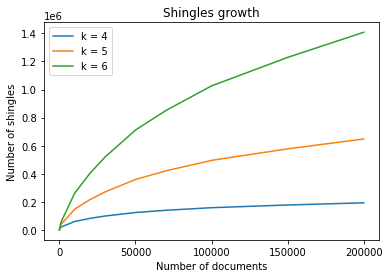

In [281]:
for k in [4, 5, 6]:
    plt.plot(
        results[k]['docs'], 
        results[k]['shingles'],
        label=f'k = {k}'
    )
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of shingles')
plt.title('Shingles growth')
plt.legend(loc='best')
plt.savefig('img/shingles_growth.png', dpi=300)

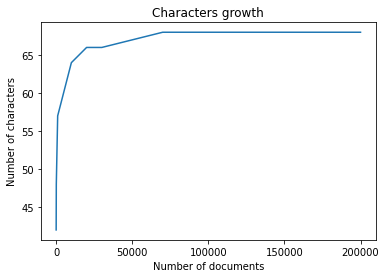

In [282]:
plt.plot(
    results[5]['docs'], 
    results[5]['characters']
)
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of characters')
plt.title('Characters growth')
plt.savefig('img/char_growth.png', dpi=300)

## Number of hash bits

In [283]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for n_bits in [12, 14, 16, 18, 19, 20, 22]:
        ckpt_path = f'checkpoints/k{k}_n_bits{n_bits}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=n_bits,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()

            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )

            sig_tp = dict(model.get_similar_pairs())
            
        else:
            start_time = timeit.default_timer()

            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            sig_tp = dict(model.get_similar_pairs())

            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                n_bits, 
                time_delta,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {n_bits} bits]:\n'
            f'\t{time_delta} seconds\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} ({ratio} Prec.) (0.1 t)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Hash bits', 
            'Time delta (s)', 
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Hash bits')

[k 3, 12 bits]:
	11.835413000000699 seconds
	422 wrong out of 1431 (0.7051013277428372 Prec.) (0.1 t)
	0.02142984546867642 MAE



[k 3, 14 bits]:
	16.462180399998033 seconds
	652 wrong out of 1482 (0.5600539811066126 Prec.) (0.1 t)
	0.026310489642649915 MAE



[k 3, 16 bits]:
	33.79630090000137 seconds
	416 wrong out of 1063 (0.6086547507055503 Prec.) (0.1 t)
	0.021908694127959573 MAE



[k 3, 18 bits]:
	104.39307990000088 seconds
	428 wrong out of 1103 (0.6119673617407072 Prec.) (0.1 t)
	0.019837901148625627 MAE



[k 3, 19 bits]:
	199.08110230000602 seconds
	507 wrong out of 1284 (0.6051401869158879 Prec.) (0.1 t)
	0.021874803255705788 MAE



[k 3, 20 bits]:
	398.3414763999972 seconds
	572 wrong out of 1296 (0.558641975308642 Prec.) (0.1 t)
	0.022330481030229783 MAE



[k 3, 22 bits]:
	1576.8013274999976 seconds
	232 wrong out of 798 (0.7092731829573935 Prec.) (0.1 t)
	0.018829716484761446 MAE



[k 4, 12 bits]:
	11.573802500002785 seconds
	192 wrong out of 334 (0.4251497005988024 Prec.) (0.1 t)
	0.022036799720198494 MAE



[k 4, 14 bits]:
	14.508103500003926 seconds
	284 wrong out of 418 (0.32057416267942584 Prec.) (0.1 t)
	0.02654190529224944 MAE



[k 4, 16 bits]:
	35.0568390000044 seconds
	217 wrong out of 332 (0.3463855421686747 Prec.) (0.1 t)
	0.02730755277220763 MAE



[k 4, 18 bits]:
	108.30533879999712 seconds
	45 wrong out of 118 (0.6186440677966102 Prec.) (0.1 t)
	0.016490885727059548 MAE



[k 4, 19 bits]:
	205.9375355000011 seconds
	146 wrong out of 248 (0.4112903225806452 Prec.) (0.1 t)
	0.028316851079987847 MAE



[k 4, 20 bits]:
	387.9654445999986 seconds
	56 wrong out of 125 (0.552 Prec.) (0.1 t)
	0.0181919660467582 MAE



[k 4, 22 bits]:
	1563.458669300002 seconds
	890 wrong out of 1017 (0.1248770894788594 Prec.) (0.1 t)
	0.04352607870342708 MAE



[k 5, 12 bits]:
	10.67984200000501 seconds
	77 wrong out of 137 (0.43795620437956206 Prec.) (0.1 t)
	0.01730916622618441 MAE



[k 5, 14 bits]:
	32.59358380000049 seconds
	69 wrong out of 116 (0.4051724137931034 Prec.) (0.1 t)
	0.022236439869469035 MAE



[k 5, 16 bits]:
	30.7132072999957 seconds
	76 wrong out of 116 (0.3448275862068966 Prec.) (0.1 t)
	0.02951342513712455 MAE



[k 5, 18 bits]:
	103.74960779999674 seconds
	52 wrong out of 83 (0.37349397590361444 Prec.) (0.1 t)
	0.021067002213734268 MAE



[k 5, 19 bits]:
	199.45628240000224 seconds
	31 wrong out of 60 (0.48333333333333334 Prec.) (0.1 t)
	0.02013987279321341 MAE



[k 5, 20 bits]:
	394.7929363000003 seconds
	154 wrong out of 192 (0.19791666666666666 Prec.) (0.1 t)
	0.032609418102356465 MAE



[k 5, 22 bits]:
	1564.7517957000018 seconds
	179 wrong out of 219 (0.182648401826484 Prec.) (0.1 t)
	0.03175532663711988 MAE



In [285]:
for k in [3, 4, 5]:
    print(results[k].round(3)) 

           Predicted pairs  Correct pairs (TP)  Wrong pairs (FP)  \
Threshold                                                          
0.05                  3534                3251               283   
0.10                   531                 360               171   
0.15                   212                  86               126   
0.20                    27                  12                15   
0.25                     9                   7                 2   
0.30                     6                   5                 1   
0.50                     4                   4                 0   

           Correct ratio (Prec.)    MAE  
Threshold                                
0.05                       0.920  0.019  
0.10                       0.678  0.021  
0.15                       0.406  0.026  
0.20                       0.444  0.028  
0.25                       0.778  0.025  
0.30                       0.833  0.005  
0.50                       1.000  0.037  
         

## Threshold choice

In [284]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for t in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]:
        ckpt_path = f'checkpoints/k{k}_t{t}'

        model = LSHModel(
            k=k,
            threshold=t,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_tp = dict(model.get_similar_pairs())
            
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()
            sig_tp = dict(model.get_similar_pairs())

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                t,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {t} threshold]:\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} ({ratio} Prec.)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Threshold', 
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Threshold')

[k 3, 0.05 threshold]:
	283 wrong out of 3534                 (0.9199207696661007 Prec.) (0.1 t)
	0.019426937060859486 MAE



[k 3, 0.1 threshold]:
	171 wrong out of 531                 (0.6779661016949152 Prec.) (0.1 t)
	0.021003652370233772 MAE



[k 3, 0.15 threshold]:
	126 wrong out of 212                 (0.4056603773584906 Prec.) (0.1 t)
	0.025759955521221803 MAE



[k 3, 0.2 threshold]:
	15 wrong out of 27                 (0.4444444444444444 Prec.) (0.1 t)
	0.027917380685045543 MAE



[k 3, 0.25 threshold]:
	2 wrong out of 9                 (0.7777777777777778 Prec.) (0.1 t)
	0.024526209331225093 MAE



[k 3, 0.3 threshold]:
	1 wrong out of 6                 (0.8333333333333334 Prec.) (0.1 t)
	0.004877777220522595 MAE



[k 3, 0.5 threshold]:
	0 wrong out of 4                 (1.0 Prec.) (0.1 t)
	0.03700787401574804 MAE



[k 4, 0.05 threshold]:
	858 wrong out of 2010                 (0.573134328358209 Prec.) (0.1 t)
	0.019743290981184394 MAE



[k 4, 0.1 threshold]:
	85 wrong out of 164                 (0.4817073170731707 Prec.) (0.1 t)
	0.020916043207784615 MAE



[k 4, 0.15 threshold]:
	17 wrong out of 27                 (0.37037037037037035 Prec.) (0.1 t)
	0.01153262540958766 MAE



[k 4, 0.2 threshold]:
	1 wrong out of 7                 (0.8571428571428571 Prec.) (0.1 t)
	0.01681463889903788 MAE



[k 4, 0.25 threshold]:
	0 wrong out of 5                 (1.0 Prec.) (0.1 t)
	0.01464596273291927 MAE



[k 4, 0.3 threshold]:
	0 wrong out of 4                 (1.0 Prec.) (0.1 t)
	0.015000000000000013 MAE



[k 4, 0.5 threshold]:
	0 wrong out of 4                 (1.0 Prec.) (0.1 t)
	0.007500000000000007 MAE



[k 5, 0.05 threshold]:
	224 wrong out of 569                 (0.6063268892794376 Prec.) (0.1 t)
	0.015400992898531328 MAE



[k 5, 0.1 threshold]:
	45 wrong out of 77                 (0.4155844155844156 Prec.) (0.1 t)
	0.02074440541651854 MAE



[k 5, 0.15 threshold]:
	20 wrong out of 28                 (0.2857142857142857 Prec.) (0.1 t)
	0.019117965790196027 MAE



[k 5, 0.2 threshold]:
	1 wrong out of 6                 (0.8333333333333334 Prec.) (0.1 t)
	0.027877300613496924 MAE



[k 5, 0.25 threshold]:
	0 wrong out of 5                 (1.0 Prec.) (0.1 t)
	0.008122699386503063 MAE



[k 5, 0.3 threshold]:
	0 wrong out of 4                 (1.0 Prec.) (0.1 t)
	0.0 MAE



[k 5, 0.5 threshold]:
	0 wrong out of 4                 (1.0 Prec.) (0.1 t)
	0.0 MAE



In [ ]:
for k in [3, 4, 5]:
    print(results[k].round(3))

## Number of hash functions

In [287]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for num_hashes in [20, 100, 200, 500, 1000]:
        ckpt_path = f'checkpoints/k{k}_n_hash{num_hashes}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=num_hashes,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_tp = dict(model.get_similar_pairs())
            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )
            
        else:
            start_time = timeit.default_timer()

            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            sig_tp = dict(model.get_similar_pairs())

            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                num_hashes,
                time_delta,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {num_hashes} hashes]:\n'
            f'\t{time_delta} seconds\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} ({ratio} Prec.)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Num hashes', 
            'Time delta (s)',
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Num hashes')

[k 3, 20 hashes]:
	27.22829540001112 seconds
	938 wrong out of 1435 (0.3463414634146341 Prec.)
	0.03969480572985107 MAE



[k 3, 100 hashes]:
	30.964506199990865 seconds
	469 wrong out of 1174 (0.600511073253833 Prec.)
	0.021881210335374594 MAE



[k 3, 200 hashes]:
	37.63534740000614 seconds
	444 wrong out of 1236 (0.6407766990291263 Prec.)
	0.018617863077281843 MAE



[k 3, 500 hashes]:
	51.32734549998713 seconds
	0 wrong out of 4 (1.0 Prec.)
	0.006492125984251973 MAE



d:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[k 3, 1000 hashes]:
	75.1967455999984 seconds
	0 wrong out of 3 (1.0 Prec.)
	0.0 MAE



[k 4, 20 hashes]:
	25.602842899999814 seconds
	310 wrong out of 389 (0.20308483290488433 Prec.)
	0.034394126629629755 MAE



[k 4, 100 hashes]:
	28.98847409999871 seconds
	110 wrong out of 210 (0.47619047619047616 Prec.)
	0.02008644785373266 MAE



[k 4, 200 hashes]:
	35.84560620000411 seconds
	92 wrong out of 192 (0.5208333333333334 Prec.)
	0.018625630085312754 MAE



[k 4, 500 hashes]:
	48.747784899998805 seconds
	0 wrong out of 3 (1.0 Prec.)
	0.0 MAE



[k 4, 1000 hashes]:
	74.12964159999683 seconds
	0 wrong out of 3 (1.0 Prec.)
	0.0 MAE



[k 5, 20 hashes]:
	25.912781499995617 seconds
	338 wrong out of 374 (0.0962566844919786 Prec.)
	0.02890606053314248 MAE



[k 5, 100 hashes]:
	29.37693530000979 seconds
	41 wrong out of 72 (0.4305555555555556 Prec.)
	0.0170392799281811 MAE



[k 5, 200 hashes]:
	32.69234080000024 seconds
	56 wrong out of 101 (0.44554455445544555 Prec.)
	0.01671494794670538 MAE



[k 5, 500 hashes]:
	48.60014280000178 seconds
	0 wrong out of 4 (1.0 Prec.)
	0.0010000000000000009 MAE



[k 5, 1000 hashes]:
	75.78343779999705 seconds
	0 wrong out of 3 (1.0 Prec.)
	0.0 MAE



## 500k Tweets comparison

### Train LSH model

MORE THAN ONE MODEL?

In [12]:
ckpt_path = f'checkpoints/d100k/k4_t0.2_n_hashes200_n_bits18'
model = LSHModel(
    k=4,
    threshold=0.4,
    num_hashes=200,
    shingle_hash_bits=18,
    track_shingles=True,
    checkpoint_path=ckpt_path
)
model = train_model(
    model=model, 
    data_path=DATA_PATH,
    num_docs=100000,
    verbose=True,
    filtering_pipeline=filtering_pipeline,
    preprocessing_pipeline=preprocessing_pipeline
)

Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip


Adding documents to model:  61%|██████    | 60583/100000 [03:37<02:10, 301.84it/s]

Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip


Found 405188 duplicates in files


In [13]:
similar_pairs = model.get_similar_pairs()

Loaded signature from row 262143


In [17]:
model.docs_dict[24750]

array([   248,   1623,   5280,  10860,  12402,  13490,  19911,  34705,
        40412,  41294,  45770,  52091,  54728,  55737,  61795,  62570,
        76767,  78246,  82567,  90942,  93201,  93319,  98424, 100120,
       100253, 103181, 107424, 110724, 114429, 121776, 129469, 131007,
       135500, 135931, 137307, 138494, 141529, 148467, 153222, 153795,
       155337, 155730, 157228, 159298, 172859, 175145, 175395, 176744,
       180122, 193825, 194674, 196924, 198607, 199221, 203087, 208679,
       211228, 214380, 221833, 229110, 232614, 239656, 239988, 248293,
       257506, 260292, 261948], dtype=uint32)

In [18]:
model.docs_dict[73828]

array([   248,   1623,   5280,  10860,  12402,  13490,  19911,  34705,
        40412,  41294,  45770,  52091,  54728,  55737,  61795,  62570,
        76767,  78246,  82567,  90942,  93201,  93319,  98424, 100120,
       100253, 103181, 107424, 110724, 114429, 121776, 129469, 131007,
       135500, 135931, 137307, 138494, 141529, 148467, 153222, 153795,
       155337, 155730, 157228, 159298, 172859, 175145, 175395, 176744,
       180122, 193825, 194674, 196924, 198607, 199221, 203087, 208679,
       211228, 214380, 221833, 229110, 232614, 239656, 239988, 248293,
       257506, 260292, 261948], dtype=uint32)

In [20]:
model.docs_dict[18697]

array([   248,    387,   1267,   1805,  13490,  16097,  17563,  21608,
        22449,  24466,  25394,  28804,  31394,  34717,  37818,  39729,
        40412,  40736,  44998,  47259,  47406,  47745,  49532,  52091,
        52110,  61795,  69603,  71063,  72252,  74270,  78727,  82784,
        82925,  90212,  91180,  93319,  94367,  97537,  98238,  98424,
       102169, 103181, 111029, 113202, 129469, 129975, 137684, 144309,
       148418, 149257, 159383, 163318, 170956, 175227, 176712, 178201,
       185072, 186903, 189474, 197828, 206805, 208077, 212882, 213632,
       214380, 227432, 227463, 227566, 230727, 235935, 245670, 248651,
       250872, 256338, 258097, 260292], dtype=uint32)

In [21]:
model.docs_dict[67726]

array([   248,    387,   1267,   1805,  13490,  16097,  17563,  21608,
        22449,  24466,  25394,  28804,  31394,  34717,  37818,  39729,
        40412,  40736,  44998,  47259,  47406,  47745,  49532,  52091,
        52110,  61795,  69603,  71063,  72252,  74270,  78727,  82784,
        82925,  90212,  91180,  93319,  94367,  97537,  98238,  98424,
       102169, 103181, 111029, 113202, 129469, 129975, 137684, 144309,
       148418, 149257, 159383, 163318, 170956, 175227, 176712, 178201,
       185072, 186903, 189474, 197828, 206805, 208077, 212882, 213632,
       214380, 227432, 227463, 227566, 230727, 235935, 245670, 248651,
       250872, 256338, 258097, 260292], dtype=uint32)

In [16]:
get_text((24750, 73828), DATA_PATH)

[(24750,
  'The head of the French Ministry of Finance Bruno Le Maire said that his country and Germany will not accept the terms of the Russian Federation to pay for Russian gas supplies in rubles\n\nGermany &amp; Italy had previously stated the same.\n\n#russia #ukraine https://t.co/cmwQzMMIdy'),
 (73828, '@MENAConflicted @threadreaderapp unroll #UkraineWar')]

In [19]:
get_text((18697, 67726), DATA_PATH)

[(18697,
  "That is what I was afraid of. You don't corner a rat leaving it without scape. Putin is too proud to lose this stupid war for a smaller army. \n\n@coinkit_ mon 0.0001 2000 $sol \n\n#Ukraine #Ukraina #UkraineConflict #UkraineRussiaConflict #UkraineWillResist #UkraineKonflikt https://t.co/TrGaMwgbef https://t.co/7DKGynJQba"),
 (67726,
  '@Gahe9 February 24 of 2022 Vladimir #Putin started the last war of the human race, #WW3. All 8 billion of us will die in it! -- People should do something to stop this!')]

In [14]:
sorted(similar_pairs, key=lambda x: -x[1])

[((19125, 63112), 1.0),
 ((18697, 67726), 1.0),
 ((49663, 60847), 1.0),
 ((24750, 73828), 1.0),
 ((40938, 83989), 1.0),
 ((57801, 71801), 1.0),
 ((7953, 90081), 1.0),
 ((17869, 87447), 1.0),
 ((36492, 61294), 1.0),
 ((50265, 61240), 1.0),
 ((37929, 78533), 1.0),
 ((42402, 95996), 1.0),
 ((11207, 15376), 1.0),
 ((32609, 61228), 1.0),
 ((41202, 62836), 1.0),
 ((18035, 77382), 1.0),
 ((54884, 64746), 1.0),
 ((41892, 75161), 1.0),
 ((5508, 91358), 1.0),
 ((31640, 66751), 1.0),
 ((44885, 77059), 1.0),
 ((30695, 70657), 1.0),
 ((29508, 95281), 1.0),
 ((58050, 92823), 1.0),
 ((1838, 64915), 1.0),
 ((40447, 61965), 1.0),
 ((20562, 75892), 1.0),
 ((57179, 86718), 1.0),
 ((29493, 98000), 1.0),
 ((47856, 69847), 1.0),
 ((18282, 64379), 1.0),
 ((6804, 14288), 1.0),
 ((54002, 77210), 1.0),
 ((16889, 77382), 1.0),
 ((5105, 70962), 1.0),
 ((95949, 96195), 1.0),
 ((20477, 35165), 1.0),
 ((23717, 88520), 1.0),
 ((330, 66851), 1.0),
 ((43381, 63405), 1.0),
 ((45226, 64981), 1.0),
 ((48788, 74859), 1.0),

In [ ]:
save checkpoint

### New test 100

In [85]:
ckpt_path = f'checkpoints/100'
model = LSHModel(
    k=4,
    threshold=0.2,
    num_hashes=200,
    shingle_hash_bits=18,
    track_shingles=True,
    checkpoint_path=ckpt_path
)
model = train_model(
    model=model, 
    data_path=DATA_PATH,
    num_docs=100,
    verbose=True,
    filtering_pipeline=filtering_pipeline,
    preprocessing_pipeline=preprocessing_pipeline
)

Adding documents to model:   0%|          | 0/100 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip


Adding documents to model:  14%|█▍        | 14/100 [00:06<00:28,  3.00it/s]

0 ukrainian air force like address misinformation publish multiple western medium outlet situation sky support nato ally 116 protectuаsky stoprussia ukraineunderattaсk
0 [   282   5280   9681  10122  10436  13305  22946  26333  28346  29623
  30043  33663  33707  37244  37494  37575  39729  44544  45770  46373
  47061  48000  51344  52763  53945  54052  54447  54919  57939  59276
  60071  62905  63511  64351  64918  67304  68830  70932  71063  80135
  82303  82342  82925  84288  86168  87118  87434  87485  91180  92520
 100026 100678 102169 102820 103181 104122 107592 110172 110573 110657
 111029 115226 115684 118075 118313 123500 128727 129699 132916 138590
 138924 139706 141590 141830 143655 143659 144070 146146 150498 151263
 151435 152738 153435 154007 154832 156809 158575 162138 162603 163535
 163681 168401 169961 170427 172227 173942 175395 178634 180507 181391
 182208 183895 184653 184695 185007 186123 186564 187465 191576 192010
 192289 193032 193282 196659 197828 198874 199710

Adding documents to model:  35%|███▌      | 35/100 [00:06<00:06, 10.25it/s]

23 govkathyhochul love covid update hunter biden neerajkhemlani hack biden covid politic vote chickendanco retr0mikey
23 [  3260   3941   4066   4431   5610   6567   7401   7415   9275  10155
  14945  22930  25117  26645  26668  27048  28520  29914  35935  39568
  46180  49944  55159  58492  67343  67526  67874  69049  70405  72823
  73114  78867  79318  79637  82867  91297  92655  94699  95820  95862
  98586 101169 101844 104632 108922 110383 110816 111463 112731 119361
 123326 128575 129193 138617 139393 140540 143805 146083 147875 152500
 153143 154702 156062 156297 157475 163544 166886 168898 176879 180122
 187801 188354 191087 194644 197270 200436 200474 205531 208852 211200
 215153 218591 219601 220858 229842 231182 231399 233352 234151 237678
 238872 241011 242256 243124 248466 249242 249894 252136 256262 256640
 261510 261824]
24 vladimirputin face mutiny russian president lose control soldier ditch uniform refuse order fight force
24 [  5203   6106   7600   9275  15519  19911 

Adding documents to model:  69%|██████▉   | 69/100 [00:06<00:01, 30.07it/s]

50 88 year old woman praskovia ukraine sit disorient frighten afraid body shake live wwii say strength war standwithukraine stoprussia
50 [  4664   7904   9735  10088  10259  13490  20735  21608  22318  23170
  25394  26333  30130  30244  33707  33753  34402  39372  39729  40727
  42111  46716  49181  50777  52054  52314  53801  55740  65158  65916
  68456  70589  71063  71640  73246  74072  77545  78246  78727  88444
  88709  89626  93497  93591  93872  94886  95583  98796 102169 103181
 103686 107025 110657 115226 122786 127289 129298 129345 130644 132033
 135085 137945 143499 146726 148121 149812 150207 153329 160783 161302
 162177 162412 162655 163535 164603 167497 170759 174200 177228 180939
 187253 192289 195764 196132 196239 197828 197883 197957 199971 200630
 203084 203764 206236 206505 207997 211898 214380 214856 215587 217161
 218386 221427 224316 224355 225570 230289 230376 231266 231945 233271
 237110 237637 237716 237932 240502 241640 242414 250514 250977 254631
 256675 26

74 [   717   1256   2954   3941   6112   8586   8816  10064  11023  12851
  15027  15519  18126  19320  19984  20409  21608  24370  29242  29716
  30600  31134  31476  37289  39479  39729  40098  42798  43408  43607
  43874  44469  46126  49251  50462  55737  59276  59423  62447  63998
  64918  64946  66342  69032  69403  69837  70773  71063  73328  79797
  81957  82178  88512  90057  92623  99614 100372 100557 102169 107176
 108922 109658 110657 111641 113357 116446 120217 124339 131794 134082
 137125 138513 140233 146364 147024 147816 149618 150443 151281 153707
 156736 158364 162913 163535 166369 169028 169191 169330 172137 176416
 177624 179250 184109 184798 190103 192232 192280 195955 196879 197828
 202724 204720 205722 208318 210730 210949 212986 214419 214837 217161
 218879 220280 220805 223257 223464 223479 223880 224254 224943 225510
 228909 229292 230323 231785 233085 235263 239548 245420 246620 252434
 254203 254834 255474 258146 260333 261265]
75 ukraine kid mariupol yes fa

In [42]:
model.docs_dict

{0: array([   282,   5280,   9681,  10122,  10436,  13305,  22946,  26333,
         28346,  29623,  30043,  33663,  33707,  37244,  37494,  37575,
         39729,  44544,  45770,  46373,  47061,  48000,  51344,  52763,
         53945,  54052,  54447,  54919,  57939,  59276,  60071,  62905,
         63511,  64351,  64918,  67304,  68830,  70932,  71063,  80135,
         82303,  82342,  82925,  84288,  86168,  87118,  87434,  87485,
         91180,  92520, 100026, 100678, 102169, 102820, 103181, 104122,
        107592, 110172, 110573, 110657, 111029, 115226, 115684, 118075,
        118313, 123500, 128727, 129699, 132916, 138590, 138924, 139706,
        141590, 141830, 143655, 143659, 144070, 146146, 150498, 151263,
        151435, 152738, 153435, 154007, 154832, 156809, 158575, 162138,
        162603, 163535, 163681, 168401, 169961, 170427, 172227, 173942,
        175395, 178634, 180507, 181391, 182208, 183895, 184653, 184695,
        185007, 186123, 186564, 187465, 191576, 192010, 19228

In [86]:
pairs = model.get_similar_pairs()

In [91]:
get_text((67, 81), DATA_PATH, filtering_pipeline)

[(67,
  '#ukrainian forces successfully conducted local counterattacks around #kyiv, towards #sumy, and in #kherson oblast and will likely take further territory—particularly northwest and east of kyiv—in the coming days. read the full report:'),
 (81,
  '#kherson and southern advance update: #ukrainian forces conducted successful counterattacks in several areas along the southern front on march 31. ukrainian forces recaptured #orlove, #zagradivka, and #kochubeyevka in northern kherson oblast.')]

In [87]:
pairs

{((2, 14), 0.2),
 ((19, 60), 0.23),
 ((31, 69), 0.235),
 ((37, 42), 0.285),
 ((49, 82), 0.245),
 ((59, 96), 0.69),
 ((67, 81), 0.215)}

### New test

In [55]:
ckpt_path = f'checkpoints/test'
model = LSHModel(
    k=4,
    threshold=0.01,
    num_hashes=200,
    shingle_hash_bits=18,
    track_shingles=True,
    checkpoint_path=ckpt_path
)

In [56]:
for doc in [
    '***PUBLIC MINT NOW LIVE***\n\nFor \n@billionaire_Wmn\n\nWin $100,000 during public sale mint. \n\nVisit https://t.co/qev7nrD3my to Mint and for further information! Good Luck!\n#nft #mint https://t.co/54daHYVlAP',
    'Welcome to our website.\nMuch information about life and what it is like to have an overview of the world is available.\nhttps://t.co/USm8E2WUGb\n#opensea #TransDayOfVisibility #TheBinJinWedding #Solana #Saitama #StandWithUkraine #blockchain #BTC #Binance https://t.co/TVTRFJN8vS'
]:
    model.add_document(
        remove_https(doc),
        preprocessing_pipeline=preprocessing_pipeline
    )

In [58]:
model.docs_dict[0]

array([   282,   1971,   3703,  12898,  13645,  18512,  19911,  23036,
        26346,  30244,  34809,  36029,  41392,  46059,  52314,  52421,
        61459,  62905,  66619,  68446,  69831,  73472,  74360,  76798,
        80135,  82094,  86336,  89498,  93703,  94495,  96082,  99111,
       100285, 104443, 105265, 108717, 112509, 112795, 117766, 123500,
       126554, 136252, 138123, 139542, 140037, 141590, 143047, 144756,
       145996, 146146, 150520, 151281, 151435, 154801, 156268, 162412,
       163794, 164905, 168306, 173223, 175880, 185649, 192781, 193282,
       197146, 197431, 200452, 206598, 214483, 216640, 217702, 219049,
       220132, 225244, 225386, 226606, 228731, 230980, 231945, 235914,
       237250, 244952, 258458, 259852], dtype=uint32)

In [57]:
model.docs_dict[1]

array([  4568,   5280,   6694,   7692,   8453,  10088,  12572,  13645,
        16506,  20318,  21130,  21608,  25297,  31127,  36329,  39729,
        40138,  42542,  44234,  44421,  44795,  45770,  46687,  47684,
        48483,  50777,  52334,  52658,  54392,  54752,  60390,  62074,
        62568,  62905,  66159,  66316,  67524,  68456,  68470,  68686,
        70918,  71063,  71348,  71792,  72174,  75088,  75303,  75832,
        76101,  76734,  77004,  79021,  80135,  81003,  81006,  85459,
        86218,  88411,  88444,  89626,  93136,  93168,  93512,  93591,
        94979,  99114, 102169, 103686, 106133, 109095, 109270, 110017,
       110550, 115352, 116031, 118004, 118378, 118381, 122234, 123127,
       123500, 124772, 125052, 126431, 126494, 130023, 131555, 132434,
       134805, 134982, 137165, 139709, 145667, 145888, 146146, 147418,
       149776, 151435, 154903, 156296, 158297, 160181, 161302, 164066,
       167623, 168713, 169961, 172494, 172859, 174849, 175395, 176732,
      

In [39]:
pairs = model.get_similar_pairs()

In [40]:
pairs

{((0, 1), 0.03), ((0, 3), 0.065)}

### MPNet embeddings

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
)
mpnet = AutoModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
).to(device)

In [ ]:
mpnet_preprocessing = [
    replace_chars,
    str.lower,
    normalize_white_space
]

In [168]:
idx_ls = np.unique(
    np.array(
        [
            list(pair)
            for pair, _ in similar_pairs
        ] 
    ).flatten()
)
text_dict = dict(get_text(idx_ls, DATA_PATH))

preprocessed_texts = []
for text in text_dict.values():
    for f in mpnet_preprocessing:
        text = f(text)
    preprocessed_texts.append(text)

encoded_input = tokenizer(
    preprocessed_texts, 
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
).to(device)

array([ 0,  1,  2,  4,  6,  9, 10, 12, 13, 14, 15, 16, 19, 20, 21, 23, 25,
       27, 28, 30, 31, 32, 35, 36, 37, 38, 39, 41, 43, 44, 45, 47, 49, 50,
       51, 52, 53, 57, 58, 63, 64, 66, 67, 69, 70, 71, 73, 75, 76, 77, 78,
       79, 86, 87, 89, 91, 92, 96, 97, 98])

In [236]:
with torch.no_grad():
    model_output = model(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

embeddings_dict = {
    key: val
    for key, val in zip(text_dict.keys(), embeddings)
}

In [237]:
lsh_sims = []
mpnet_sims = []

for ((x_idx, y_idx), lsh_sim) in similar_pairs:
    lsh_sims.append(lsh_sim)
    mpnet_sims.append(
        torch_cosine_similarity(
            embeddings_dict[x_idx],
            embeddings_dict[y_idx],
        )
    )

### Compare rankings

In [239]:
kendalltau(lsh_sims, mpnet_sims)

KendalltauResult(correlation=0.4790651278562069, pvalue=9.727797364038488e-09)

In [241]:
spearmanr(lsh_sims, mpnet_sims)

SpearmanrResult(correlation=0.6255073800230813, pvalue=1.1872875150277376e-09)

In [269]:
ckpt_path = f'checkpoints/test/test1'
model = LSHModel(
    k=5,
    threshold=0.1,
    num_hashes=100,
    shingle_hash_bits=16,
    track_shingles=True,
    checkpoint_path=ckpt_path
)

num_docs = 100

files = []
data_path = DATA_PATH

for name in os.listdir(data_path):
    full_path = os.path.join(data_path, name)
    if os.path.isfile(full_path):
        files.append(full_path)

duplicates = 0
count = num_docs

with tqdm(
    total=num_docs,
    desc='Adding documents to model',
    leave=False
) as pbar:
    for file in files:
        if count == 0:
            break
        
        print(f'Reading file {file}')
        df = pd.read_csv(
            file, 
            compression='gzip', 
            index_col=0,
            encoding='utf-8', 
            quoting=csv.QUOTE_ALL,
            low_memory=False
        )

        df = df[df['language'] == 'en']

        for filter_f in filtering_pipeline:
            df['text'] = df['text'].apply(filter_f)

        df_unique = df.drop_duplicates(subset=['text'])
        duplicates += len(df) - len(df_unique)

Adding documents to model:   0%|          | 0/100 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip


KeyboardInterrupt: 

In [256]:
# List of Tuples
matrix = [('22', '34', '23'),
         ('33', '31', '11'),
         ('44', '16', '21'),
         ('55', '32', '22'),
         ('66', '33', '27'),
         ('77', '35', '11')
         ]
# Create a DataFrame object
dfObj = pd.DataFrame(matrix, columns=list('xyz'), index=list('abcdef'))

In [257]:
dfObj

,x,y,z
a,22,34,23
b,33,31,11
c,44,16,21
d,55,32,22
e,66,33,27
f,77,35,11


In [268]:
dfObj['z'] = dfObj['z'].apply(remove_https)
dfObj

,x,y,z
a,22,34,23
b,33,31,11
c,44,16,21
d,55,32,22
e,66,33,27
f,77,35,11


In [267]:
remove_https('ababss')

'ababss'

In [62]:
matrix = [('22', '34', '23'),
         ('33', '31', '11'),
         ('44', '16', '21'),
         ('22', '34', '23'),
         ('66', '33', '27'),
         ('22', '34', '23')
         ]
# Create a DataFrame object
dd = pd.DataFrame(matrix, columns=list('xyz'), index=list('abcdef'))
dd

,x,y,z
a,22,34,23
b,33,31,11
c,44,16,21
d,22,34,23
e,66,33,27
f,22,34,23


In [63]:
dd1 = dd.drop_duplicates()
dd1

,x,y,z
a,22,34,23
b,33,31,11
c,44,16,21
e,66,33,27


In [67]:
dd.loc[dd1.index]

,x,y,z
a,22,34,23
b,33,31,11
c,44,16,21
e,66,33,27
